In [4]:
from Phi import *
import torch
from torch import nn, optim
import torch.nn.functional as F
from torchdiffeq import odeint, odeint_adjoint
from utils.ToyModels import *
import matplotlib.pyplot as plt

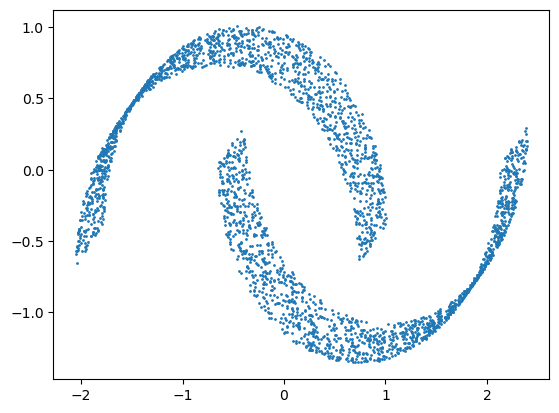

In [14]:
plt.scatter(*generate_moon_data(n_samples=3000, noise=2e-1)[0].T, s=1.)

In [57]:
class OdeFunc(nn.Module):
    def __init__(self, d: int, m:int, nTh: int):
        super(OdeFunc, self).__init__()
        self.d = d
        self.m = m
        self.nTh = nTh
        self.net = Phi(self.nTh, self.m, self.d)
    
    def forward(self, t, x):
        x = x[:, :self.d]
        # z = F.pad(x,[0,1,0,0],  value=t)
        z = torch.cat((x, t*torch.ones(x.shape[0],1)), 1)
        gradPhi, trH = self.net.trHess(z)
        dx = - gradPhi[:,:self.d]
        dl = - trH.unsqueeze(1)
        dv = 0.5 * torch.sum(torch.pow(dx, 2), 1, keepdim=True)
        dr = torch.abs(-gradPhi[:,-1].unsqueeze(1) +  dv)
        return torch.cat((dx, dl, dv, dr), 1)

In [74]:
d = 2
m = 10
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
OTFlow = OdeFunc(d,m, 2).to(device)

In [67]:
def get_batch(n_smple):
    x, _ = generate_moon_data(n_samples=n_smple, noise=2e-1)
    return x

In [76]:
optimizer = optim.Adam(OTFlow.parameters(), lr=1e-3)
t0 = 0
t1 = 10

for _ in range(1000):
    optimizer.zero_grad()
    x = get_batch(1000).to(device)
    x = F.pad(x,[0,3,0,0],  value=0).to(device)
    t = torch.tensor([t0, t1], dtype=torch.float32) .to(device)
    x0 = odeint(OTFlow, x, t, method='dopri5').to(device)
    loss = compute_loss(x0)
    loss.backward()
    optimizer.step()

    print(loss.item())


    

504654.28125
495625.65625
486720.34375
477862.78125
469126.71875
460509.40625
451995.5625
443595.90625


KeyboardInterrupt: 

In [62]:
torch.randn(2,5)[:,]

tensor([[-0.7578, -1.1828, -1.6347, -0.8153, -0.7638],
        [-0.0907, -0.5955, -0.8134, -0.1275, -0.1994]])

In [44]:
def compute_loss(x: torch.Tensor):
    d = x.shape[1] - 3
    C = 1/2 * torch.sum(torch.pow(x[:, :d], 2), dim=1) - x[:, -3] + torch.log(torch.tensor([2]) * torch.pi)
    L = x[:,-2].mean()
    R = x[:,-1].mean()
    return C.mean() + L + R